<a href="https://colab.research.google.com/github/yongchun780/ai_project_vgg/blob/main/Ai_Project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Defect Detection in Manufacturing Using VGG


## Step 1: Dataset Preparation


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/mvtec_anomaly_detection')

# Verify the directory change
!ls


best_model.h5  capsule			  grid	    license.txt  readme.txt  toothbrush  zipper
bottle	       carpet			  hazelnut  metal_nut	 screw	     transistor
cable	       defect_detection_model.h5  leather   pill	 tile	     wood


In [4]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)
    return images, labels

def load_category_data(base_path, category):
    train_good_path = os.path.join(base_path, category, 'train', 'good')
    test_path = os.path.join(base_path, category, 'test')

    # Load defect-free images from the training set
    train_images, train_labels = load_images_from_folder(train_good_path, label=0)

    # Load defective images from the test set
    defective_images = []
    defective_labels = []

    for defect_type in os.listdir(test_path):
        defect_type_path = os.path.join(test_path, defect_type)
        if defect_type != 'good' and os.path.isdir(defect_type_path):
            defect_images, defect_labels = load_images_from_folder(defect_type_path, label=1)
            defective_images.extend(defect_images)
            defective_labels.extend(defect_labels)

    # Load defect-free images from the test set
    test_good_path = os.path.join(test_path, 'good')
    good_test_images, good_test_labels = load_images_from_folder(test_good_path, label=0)

    # Combine test images and labels
    test_images = defective_images + good_test_images
    test_labels = defective_labels + good_test_labels

    return train_images, train_labels, test_images, test_labels

# Define base path and categories
base_path = '/content/drive/MyDrive/mvtec_anomaly_detection'
categories = ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


# Initialize lists to hold all data
all_train_images = []
all_train_labels = []
all_test_images = []
all_test_labels = []

# Load and preprocess data for each category
for category in categories:
    train_images, train_labels, test_images, test_labels = load_category_data(base_path, category)
    all_train_images.extend(train_images)
    all_train_labels.extend(train_labels)
    all_test_images.extend(test_images)
    all_test_labels.extend(test_labels)

# Convert to numpy arrays
all_train_images = np.array(all_train_images)
all_train_labels = np.array(all_train_labels)
all_test_images = np.array(all_test_images)
all_test_labels = np.array(all_test_labels)

# Combine and shuffle data
def shuffle_data(images, labels):
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    return images, labels

all_train_images, all_train_labels = shuffle_data(all_train_images, all_train_labels)
all_test_images, all_test_labels = shuffle_data(all_test_images, all_test_labels)

print("Training data shape:", all_train_images.shape)
print("Training labels shape:", all_train_labels.shape)
print("Test data shape:", all_test_images.shape)
print("Test labels shape:", all_test_labels.shape)


Training data shape: (3629, 224, 224, 3)
Training labels shape: (3629,)
Test data shape: (1725, 224, 224, 3)
Test labels shape: (1725,)


## Step 2: Model Development with VGG16

### 2.1 Load a Pre-trained VGG16 Model and Add Custom Layers

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### 2.2 Train the Model

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=5, mode='min')
]

# Train the model
history = model.fit(
    all_train_images, all_train_labels,
    epochs=50,
    validation_split=0.2,
    batch_size=16,  # Adjust batch size based on memory constraints
    callbacks=callbacks
)


Epoch 1/50
182/182 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9983 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


182/182 [==============================] - 2437s 13s/step - loss: 0.0040 - accuracy: 0.9983 - val_loss: 3.7610e-31 - val_accuracy: 1.0000
Epoch 2/50
182/182 [==============================] - 2422s 13s/step - loss: 2.5132e-28 - accuracy: 1.0000 - val_loss: 3.7610e-31 - val_accuracy: 1.0000
Epoch 3/50
182/182 [==============================] - 2398s 13s/step - loss: 8.3310e-28 - accuracy: 1.0000 - val_loss: 3.7610e-31 - val_accuracy: 1.0000
Epoch 4/50
182/182 [==============================] - 2398s 13s/step - loss: 1.3000e-27 - accuracy: 1.0000 - val_loss: 3.7610e-31 - val_accuracy: 1.0000
Epoch 5/50
182/182 [==============================] - 2347s 13s/step - loss: 3.3677e-27 - accuracy: 1.0000 - val_loss: 3.7610e-31 - val_accuracy: 1.0000
Epoch 6/50
182/182 [==============================] - 2394s 13s/step - loss: 8.3972e-28 - accuracy: 1.0000 - val_loss: 3.7610e-31 - val_accuracy: 1.0000


### 2.3 Evaluate the Model

In [7]:
# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(all_test_images, all_test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


54/54 [==============================] - 1086s 20s/step - loss: 139.3522 - accuracy: 0.2707
Test Accuracy: 27.07%


## Step 3: Model Evaluation and Analysis

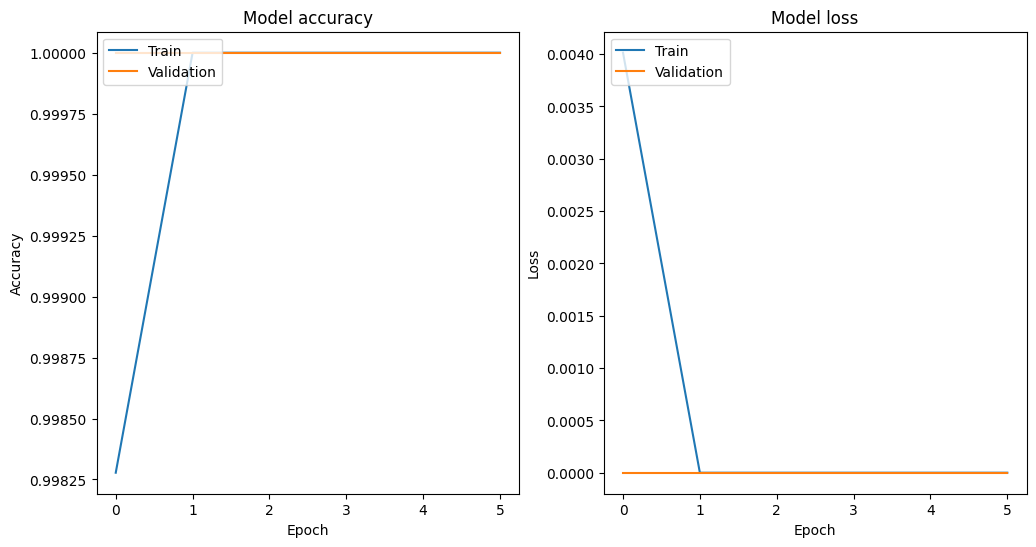

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Step 4: Save and Deploy the Model

In [9]:
model.save('defect_detection_model.h5')


## Step 5: Model Test

### 5.1 Load Model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load the saved model
model = load_model('/content/drive/MyDrive/mvtec_anomaly_detection/defect_detection_model.h5')

### 5.2 Preprocess New Images

In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to match the input size of the model
    img = img.astype('float32') / 255.0  # Normalize the pixel values
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match the input shape for the model
    return img


### 5.3 Make Predictions

In [17]:
# Path to the new image
new_image_path = '/content/drive/MyDrive/test_images/test_bottle3.jpg'

# Preprocess the image
preprocessed_image = preprocess_image(new_image_path)

# Make a prediction
prediction = model.predict(preprocessed_image)
print(prediction)

# Interpret the prediction
if prediction < 0.5:
    print("The component is: Good")
else:
    print("The component is: Defective")


1/1 [==============================] - 1s 745ms/step
[[1.11937894e-07]]
The component is: Good
